<a href="https://colab.research.google.com/github/rishavb123/QuantumPhysicsWithDeepLearning/blob/master/Solving_the_Schrodinger_Equation_with_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Schrodinger Equation with Deep Neural Networks

The idea behind this project is to speed up the solutions of the Schrodinger equation, an important equation that shows up all throughout quantum mechanics, using a neural network to approximate the solutions that we numerically calculate. I use the Runge-Kutta method to numerically solve the one-dimensional infinite asymmetric well problem first for many different potential functions inside the well, and then use a neural network that takes in these potentials as the input and then predicts the energy of the particle in this quantum state and the wavefunction describing the probability of the particle. Another conclusion that we came to see is that the feedforward or the use of the neural network to solve the Schrodinger equation has a more consistent time, staying close to the meantime, or low standard deviation, while the numeric method sometimes took much longer or shorter than the meantime, creating a sense of inconsistency that the neural network solution did not have.

[Github Link](https://github.com/rishavb123/QuantumPhysicsWithDeepLearning)

Just some paramaters to set before running this.

In [0]:
redo_all = False
redo_none = True

retrain_model = (True or redo_all) and not redo_none
wanna_save = (False or redo_all)
regenerate_data = (False or redo_all) and not redo_none
make_new_graphs = (False or redo_all) and not redo_none
save_to_drive = True and not redo_none

Here are some relavant installs and imports

In [2]:
%tensorflow_version 2.x
!pip install --upgrade pip
!pip install numpy matplotlib func-timeout tensorflow==2.*

TensorFlow 2.x selected.
     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 44 kB 1.2 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=7ab19ec97982fdc707acd3e53f164a34a90ccd0d6513b4cd0062526ac77e79fe
  Stored in directory: /root/.cache/pip/wheels/f5/f7/77/59440b4bf3fb41755539a8891b0e01164c4ff597ed2c1742fb
Successfully built func-timeout


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import time
import tensorflow as tf
from func_timeout import func_timeout
from google.colab import drive

Checking tensorflow version: should be `'2.1.0'`

In [4]:
tf.__version__

'2.1.0'

Mounting our google drive to the notebook

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


And now downloading the files we will load in from google drive

In [0]:
if not redo_all:
    t = 1581956000
    directory = "\"drive/My Drive/Colab Notebooks/Solving Schrodinger Equation Data/Data-" + str(t) + "\""
    def get_file(file_name):
        file_dir = directory + "/" + file_name
        ! cp $file_dir "./"
    if not regenerate_data:
        get_file('dataset.npy')
    if not retrain_model:
        get_file('loss_history.npy')
        get_file('model_weights.h5')
    if not make_new_graphs:
        get_file('complexity_graphs.npy')

Some code to make the graphs look better in dark mode for Google Collab.

In [0]:
plt.style.use('dark_background')

The **Schrodinger equation** in one dimension is as follows
$$i\hbar\dfrac{\partial\psi(x, t)}{\partial t} = -\dfrac{\hbar^2}{2m}\dfrac{\partial^2\psi(x, t)}{\partial x^2} + V(x)\psi(x, t)$$
Now, letting $\psi(x, t) = u(x)T(t)$ for seperation of variables, we have
$$i\hbar u(x)\dfrac{dT(t)}{dt} = T(t)\big(-\dfrac{\hbar^2}{2m}\dfrac{d^2u(x)}{dx^2} + V(x)u(x)\big)$$
then dividing by $u(x)T(t)$,
$$i\hbar\dfrac{1}{T(t)}\dfrac{dT(t)}{dt} = -\dfrac{1}{u(x)}\dfrac{\hbar^2}{2m}\dfrac{d^2u(x)}{dx^2} + V(x) = E$$
which is set to a time and space independent constant since each side is only dependent on $x$ or $t$, which are two independent variables.

Solving the time only equation:
$$i\hbar\dfrac{dT(t)}{dt} = ET(t)$$
is fairly simple and yields the solution
$$T(t) = \exp(\dfrac{-iEt}{\hbar})$$
Now, the solution to the Schrodinger equation is
$$\psi(x, t) = u(x)\exp(\dfrac{-iEt}{\hbar})$$
where $u(x)$ solves the **time-independent schrodinger equation**
$$-\dfrac{\hbar^2}{2m}\dfrac{d^2u(x)}{dx^2} + V(x)u(x) = Eu(x)$$
which I will use numeric methods and soon a neural network to solve. 

Lets define some physical constants

In [0]:
m = 9.1094e-31 # Mass of an electron
hbar = 1.0546e-34 # Planck's constant over 2 * pi
e = 1.6022e-19 # charge of an electron
L = 5.2918e-11 # width of the well
v0 = 2.3e5 # potential different between 0 and well --> just for show

The only thing that changes in this equation between different situations or setups is the $V(x)$ so let's define it as an infinite square well here:



In [0]:
def V(x):
    if x < 0 or x > L:
        return v0 # really infinite
    return 0

Also, let us make a function that wraps other potential functions to visualize them.

In [0]:
def wrap_v(V, v0=v0):
    def new_v(x):
        if x < 0 or x > L:
            return v0
        else:
            return V(x)
    return new_v

Here is a method to plot a function within a certain range $(a, b)$.

In [0]:
plot_n = 100

def plot_func(func, a, b, title=None, new_figure=True):
    func = np.vectorize(func)
    x = np.linspace(a, b, plot_n)
    y = func(x)
    if new_figure:
        plt.figure()
    if title != None:
        plt.title(title)
    plt.plot(x, y)
    plt.show()

To plot multiple functions on the same graph, we can make another method:

In [0]:
def plot_funcs(funcs, a, b, labels=None, title=None, new_figure=True):
    x = np.linspace(a, b, plot_n)
    ys = [np.vectorize(func)(x) for func in funcs]
    if new_figure:
        plt.figure()
    if title != None:
        plt.title(title)
    if labels == None:
        [plt.plot(x, y) for y in ys]
    else:
        [plt.plot(x, ys[i], label=labels[i]) for i in range(len(ys))]
        plt.legend()
    plt.show()

Now, to visualize this potential function, let's graph it

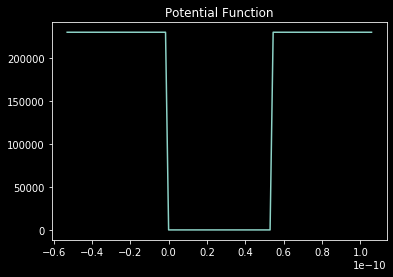

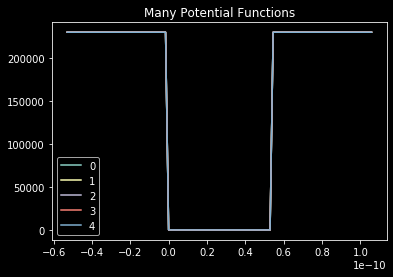

In [58]:
n = 5
plot_func(V, -L, L * 2, title='Potential Function')
plot_funcs([V for i in range(n)], -L, L * 2, range(n), title='Many Potential Functions')

We will use the Runge-Kutta method to solve the second order linear differential equation, or the eigenvalue equation,
$$-\dfrac{\hbar^2}{2m}\dfrac{d^2\psi(x)}{dt^2} + V(x)\psi(x) = E\psi(x)$$
where we have renamed $u(x)$ to $\psi(x)$

To use the fourth-order vector Runge-Kutta method to solve our differential equation, we must make some modifications. First we let $\phi(x) = u'(x)$ making our system of equations
$$\dfrac{d\psi(x)}{dx} = \phi(x)$$
$$-\dfrac{\hbar^2}{2m}\dfrac{d\phi(x)}{dx} + V(x)\psi(x) = E\psi(x)$$
we can rewrite the second equation as 
$$\dfrac{d\phi(x)}{dx} = \dfrac{2m}{\hbar^2}(V(x) - E)\psi(x)$$
Now if we define a new vector
$$\vec{r}(x) = (\psi(x) \quad \phi(x))^T$$
and rewrite our system as
$$\dfrac{d\vec{r}}{dx} = f(\vec{r}, x)$$
where f is a vector function defined as 
$$f_0(\vec{r}, x) = r_1$$
$$f_1(\vec{r}, x) = \dfrac{2m}{\hbar^2}(V(x) - E)r_0$$
or in code

In [0]:
def f(r, x, E):
    return np.array([r[1], 2*m / (hbar ** 2) * (V(x) - E) * r[0]])

Now applying the fourth-order vector of the Runge-Kutta method to solve the wavefunction given a particular energy E. Here is some pseudocode for how the Runge-Kutta method works on $(a, b)$ with $N$ points.


```
N, a, b
R = []
r = 0
for t in T:
    R.append(r)
    k1 = h * f(r, t)
    k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
    k2 = h * f(r + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(r + k3, t + h)
    r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

```

which gives us our solution in discrete time steps: $R$. This method works whether r is a vector or scalar.


In [0]:
def solve(E, a = 0, b = L, N = 1000):

    h = (b - a) / N

    psi = 0.0
    phi = 1.0
    r = np.array([psi, phi], float)

    x_points = np.arange(a, b, h)
    psi_points = []

    for x in x_points:
        psi_points.append(r[0])
        k1 = h * f(r, x, E)
        k2 = h * f(r + 0.5 * k1, x + 0.5 * h, E)
        k3 = h * f(r + 0.5 * k2, x + 0.5 * h, E)
        k4 = h * f(r + k3, x + h, E)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    x_points = np.append(x_points, b)
    
    psi_points.append(r[0])

    return x_points, np.array(psi_points), r[0]

To find the ground state energy eigenvalue, we can use the secant method to find the roots of the result of psi at L

In [0]:
def find_energy_eigenvalue(E1, E2):
    psi2 = solve(E1)[2]
    epsilon = e / 1000

    while abs(E1 - E2) > epsilon:
        psi1, psi2 = psi2, solve(E2)[2]
        E1, E2 = E2, E2 - psi2 * (E2 - E1) / (psi2 - psi1)

    return E2

Now, the last step to our calculate is to normalize the wavefunction. First we need an integration method, we will use the simpson's rule.

In [15]:
def integrate(arr, h):
    N = len(arr)
    return 1/3 * h * (arr[0] + arr[N - 1] + 4 * sum([arr[2*k - 1] for k in range(1, int(N/2) + 1)]) + 2 * sum([arr[2*k] for k in range(1, int(N/2))]))

integrate([x**2 for x in np.arange(0, 5.1, 0.1)], 0.1) # should be 41.6666666666666666

41.666666666666664

Now, we normalize our wavefunction by calculating
$$\int_0^L |\psi(x, t)|^2 dx = I$$
assuming the wavefunction is 0 outside of $x \in (0, L)$. We can show that 
$|\psi(x, t)|^2 = |\psi(x)|^2$ since $T(t)$ is just an imaginary exponent. So, we just calculate
$$\int_0^L |\psi(x)|^2 dx = I$$
Now, we set out wavefunction to 
$$\psi(x) = \dfrac{1}{\sqrt{I}}\psi(x)$$
so that our new $\psi(x)$ satifies
$$\int_0^L |\psi(x)|^2 dx = 1$$

In [0]:
def normalize(psi_points):
    return 1/math.sqrt(integrate([psi ** 2 for psi in psi_points], L / len(psi_points))) * np.array(psi_points)

And now outputting and plotting our results

Excepted E (for n=1): 134.28637170133268 eV
E = 134.28637169369105 eV


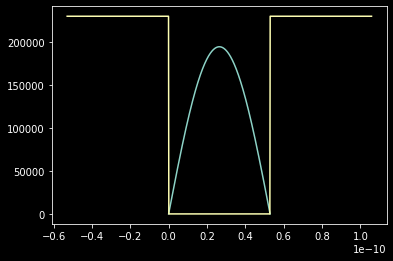

In [17]:
E = find_energy_eigenvalue(0, e)

# From our analytical solution
n = 1
expected_E = hbar ** 2 * math.pi ** 2 * n ** 2 / (2 * m * L ** 2)

print("Excepted E (for n=1):", (expected_E / e), "eV")
print("E =", E / e, "eV")

x_points, psi_points, psi_final = solve(E) # , a = -L, b = L * 2)
psi_points = normalize(psi_points)
x_points2 = np.arange(-L, L * 2, 3 * L / 1000);

plt.plot(x_points, psi_points)
plt.plot(x_points2, np.vectorize(V)(x_points2))
plt.show()

Now if we redefine V(x) so we have an asymetric quantum well, with
$$V(x) = V_0 (\dfrac{x}{L})^p(\dfrac{x}{L} - 1)^q$$

inside the well. Where varying $p$ and $q$ changes our potential.

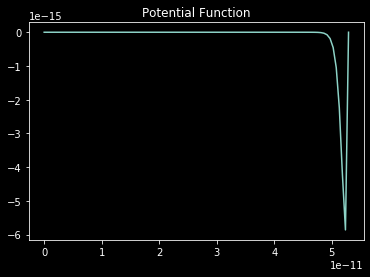

In [18]:
V0 = 10000000 * e
p = 100
q = 1
scale = 0.9999999999999 # to avoid division by 0

def V(x):
    if x < 0 or x > L:
        return v0
    return V0 * (x/L + (1 - scale)) ** p * (scale * x/L - 1) ** q

plot_func(V, 0, L, title='Potential Function')

Now solving for the ground state energy and the ground state wavefunction follows the same method.

E = 10.71957929310706 eV


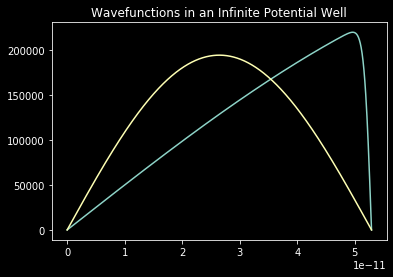

In [19]:
E = find_energy_eigenvalue(0, e)

print("E =", E / e, "eV")

x_points2, psi_points2, psi_final = solve(E)
psi_points2 = normalize(psi_points2)

plt.title('Wavefunctions in an Infinite Potential Well')
plt.plot(x_points2, psi_points2) # our new solution (blue)
plt.plot(x_points, psi_points) # our solution for the infinite square well (orange)
plt.show()

Now just putting everything together into one method that takes in an array of sample points of the potential inside of our infinite well.



In [0]:
def solve_schrodinger_equation(V, N=1000):

    h = L / N

    def f(r, x, E):
        return np.array([r[1], 2*m / (hbar ** 2) * (V(x) - E) * r[0]])

    def solve(E):

        psi = 0.0
        phi = 1.0
        r = np.array([psi, phi], float)

        x_points = np.arange(0, L, h)
        psi_points = []

        for x in x_points:
            psi_points.append(r[0])
            k1 = h * f(r, x, E)
            k2 = h * f(r + 0.5 * k1, x + 0.5 * h, E)
            k3 = h * f(r + 0.5 * k2, x + 0.5 * h, E)
            k4 = h * f(r + k3, x + h, E)
            r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

        return x_points, psi_points, r[0]

    def find_energy_eigenvalue(E1, E2):
        psi2 = solve(E1)[2]
        epsilon = e / 1000

        while abs(E1 - E2) > epsilon:
            psi1, psi2 = psi2, solve(E2)[2]
            E1, E2 = E2, E2 - psi2 * (E2 - E1) / (psi2 - psi1)

        return E2

    def integrate(arr, h):
        N = len(arr)
        return 1/3 * h * (arr[0] + arr[N - 1] + 4 * sum([arr[2*k - 1] for k in range(1, int(N/2) + 1)]) + 2 * sum([arr[2*k] for k in range(1, int(N/2))]))

    def normalize(psi_points):
        return 1/math.sqrt(integrate([psi ** 2 for psi in psi_points], L / len(psi_points))) * np.array(psi_points)

    E = find_energy_eigenvalue(0, e)

    x_points, psi_points, psi_final = solve(E)

    return x_points, normalize(psi_points), E


Now using this method, let's solve the schrodinger equation with a linear potential inside the potential well and time it.

Took 0.497347354888916 seconds
E = 4.151055920032114e-16 J
Checking normalization: 1 = 0.9999999999999997


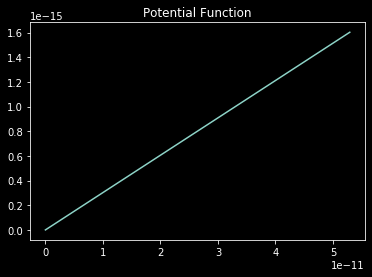

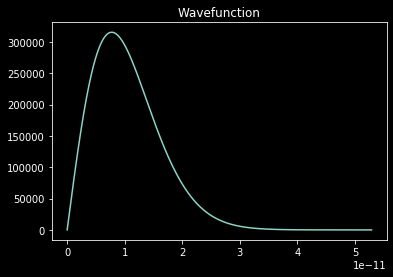

In [21]:
V = lambda x: x / L * 1e4 * e
cur_time = time.time()
x_points, psi_points, E = solve_schrodinger_equation(V)
print("Took", time.time() - cur_time, "seconds")
print("E =", E, "J")
print("Checking normalization: 1 =", integrate([psi ** 2 for psi in psi_points], L / len(psi_points)))
plot_func(V, 0, L, title='Potential Function')
plt.title('Wavefunction')
plt.plot(x_points, psi_points)
plt.show()

Now we will try to implement a neural network that will learn how to solve the Schrodinger equation and make use of patterns that we do not know to approximate the solution.

First, we need a machine learning library to use for neural networks. I will use tensorflow, a well known machine learning library created and managed by Google.

Here I will use a basic example (mnist) to show how it works.

First, we need to load in and preprocess the data

In [0]:
def preprocess(lines):
    
    def to_int_arr(s):
        return [int(x) for x in s.split(",")]
    
    def one_hot(i, l):
        arr = np.zeros(l)
        arr[i] = 1
        return arr

    data = [to_int_arr(l) for l in lines]

    inputs = np.array([x[1:] for x in data])
    outputs = np.array([one_hot(x[0], 10) for x in data])
    
    return inputs, outputs

train_file = open('./sample_data/mnist_train_small.csv')
train_lines = train_file.readlines()
train_file.close()
train_inputs, train_outputs = preprocess(train_lines)

test_file = open('./sample_data/mnist_test.csv')
test_lines = test_file.readlines()
test_file.close()
test_inputs, test_outputs = preprocess(test_lines)

Now let's actually train and test a neural network on this data

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_dim=len(train_inputs[0])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train_outputs[0]), activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_outputs, epochs=5)
model.evaluate(test_inputs, test_outputs)

Train on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 5s 247us/sample - loss: 3.8913 - accuracy: 0.7279
Epoch 2/5
20000/20000 [==============================] - 4s 201us/sample - loss: 0.6023 - accuracy: 0.8478
Epoch 3/5
20000/20000 [==============================] - 4s 212us/sample - loss: 0.4350 - accuracy: 0.8852
Epoch 4/5
20000/20000 [==============================] - 4s 212us/sample - loss: 0.3656 - accuracy: 0.8996
Epoch 5/5
10000/10000 [==============================] - 1s 91us/sample - loss: 0.2101 - accuracy: 0.9434


[0.21008717231545598, 0.9434]

Now that we have seen how the neural network class functions, let's use it to approximate the solutions to the Schrodinger equation. Out inputs will be the $N$ sample points from $V(x)$ and our output will be the $N$ sample points from $\psi(x)$.

So, first, we must generate / load in our dataset. To gain some insights in the amount of time it will take to generate our data and to figure out how much data and some other parameters of the generation we will analyze some graphs and predictions of how much time each configuration will take, and then choose parameters that generate the maximum amount of varied data in a reasonable time.

Now, just to plot a couple generated potentials and look at how complexity affects the time to compute the potential functions and wavefunctions.



In [0]:
def generate_potential(potential_type, n, p=5):
    V0 = 10 ** p * e
    if potential_type == 'step':
        points = [(np.random.random() * L, 2 * np.random.random() * V0 - V0)]
        for i in range(n):
            points.append((np.random.random() * L, 2 * np.random.random() * V0 - V0))
        return lambda x: points[np.argmin([abs(x - p[0]) for p in points])][1]
    elif potential_type == 'linear':
        points = [(0, 2 * np.random.random() * V0 - V0), (L, 2 * np.random.random() * V0 - V0)]
        for i in range(n):
            points.append((np.random.random() * L, 2 * np.random.random() * V0 - V0))
        points.sort(key=lambda p: p[0])
        def V(x):
            for i in range(1, len(points)):
                if points[i][0] >= x:
                    return (x - points[i - 1][0]) * ((points[i][1] - points[i - 1][1]) / (points[i][0] - points[i - 1][0])) + points[i - 1][1]
        return V
    elif potential_type == 'fourier':
        n = n + 2
        a = [np.random.random() * 2 - 1 for i in range(n)]
        b = [np.random.random() * 2 - 1 for i in range(n)]
        f = lambda x: sum([a[i] * math.cos(2 * math.pi * i * x / L) + a[i] * math.sin(2 * math.pi * i * x / L) for i in range(n)])
        I = integrate([abs(f(i / 1000 * L)) for i in range(1000)],  L / 1000)
        return lambda x : f(x) / I * (V0 * L)

Initialize our graph data for the times versus complexity.

In [0]:
complexities = []
potential_times = []
wavefunction_times = []

The next code cell generates the potentials and solves the wavefunction for 50 different complexities and then stores the times it took to perform these steps into our arrays we will graph later. 

In [0]:
if make_new_graphs:
    for complexity in range(50):
        def run():
            labels = ['step', 'linear', 'fourier']

            print("Generating Potentials for Complexity", complexity)
            cur_time = time.time()
            potentials = [generate_potential(s, complexity) for s in labels]
            pt = time.time() - cur_time
            print("Done - Took", pt, "seconds\n")

            print("Solving for Wavefunctions and Energies:")
            cur_time = time.time()
            wavefunctions = [solve_schrodinger_equation(potential)[1] for potential in potentials]
            wt = time.time() - cur_time
            print("Done - Took", wt, "seconds\n")

            print("Checking Normalization (all should be 1):", [integrate([psi * psi for psi in wavefunction], L / len(wavefunction)) for wavefunction in wavefunctions])

            plot_funcs(potentials, 0, L, labels=labels, title='Potential Functions')
            print()
            x_points = np.arange(0, L, L / 1000)
            plt.figure()
            plt.title('Wavefunctions')
            for i in range(len(labels)):
                plt.plot(x_points, wavefunctions[i], label=labels[i])
            plt.legend()
            plt.show()

            complexities.append(complexity)
            potential_times.append(pt)
            wavefunction_times.append(wt)
        try:
            func_timeout(60, run)
        except:
            print("Data Point with Complexity", complexity, "timed out\n")
else:
    with open('complexity_graphs.npy', 'rb') as f:
        complexities, potential_times, wavefunction_times = np.load(f)

Now, let's save this data into a file.

In [0]:
if make_new_graphs:
    with open('complexity_graphs.npy', 'wb') as f:
        np.save(f, np.array([complexities, potential_times, wavefunction_times]))

Now, we plot our different times vs the complexity.

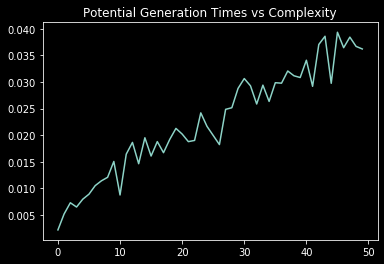

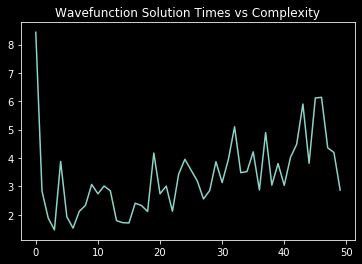

In [28]:
plt.title('Potential Generation Times vs Complexity')
arr = sorted(zip(complexities, potential_times, wavefunction_times), key=lambda x: x[0])
complexities = []
potential_times = []
wavefunction_times = []
for a in arr:
    complexities.append(a[0])
    potential_times.append(a[1])
    wavefunction_times.append(a[2])

Nc = len(complexities)

plt.plot(complexities, potential_times)
plt.figure()
plt.title('Wavefunction Solution Times vs Complexity')
plt.plot(complexities, wavefunction_times)
plt.show()

If you want to get rid of a datapoint since it is an outlier.

In [0]:
ind = 2

# complexities = complexities[0:ind] + complexities[ind + 1:]
# potential_times = potential_times[0:ind] + potential_times[ind + 1:]
# wavefunction_times = wavefunction_times[0:ind] + wavefunction_times[ind + 1:]

Let us perform linear regression on this data to help us predict how much time even higher complexities will take.



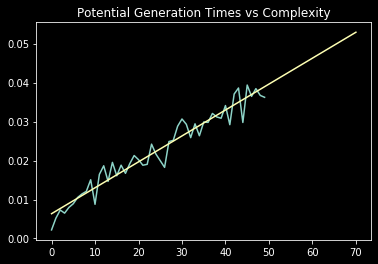

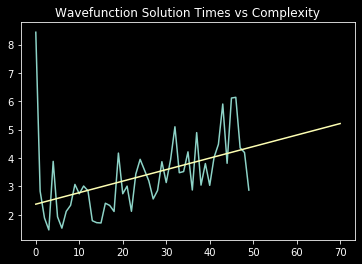

In [30]:
def linear_regression(X, Y):
    N = len(X)
    b = (N * sum([X[i] * Y[i] for i in range(N)]) - sum(X) * sum(Y)) / (N * sum([x * x for x in X]) - sum(X)**2)
    a = (sum(Y) - b * sum(X)) / N
    return lambda x: a + b * x

plt.plot(complexities, potential_times)
potential_time_predictor = linear_regression(complexities, potential_times)
plot_func(potential_time_predictor, 0, 70, 'Potential Generation Times vs Complexity', new_figure=False)

plt.figure()
plt.plot(complexities, wavefunction_times)
wavefunction_time_predictor = linear_regression(complexities, wavefunction_times)
plot_func(wavefunction_time_predictor, 0, 70, title='Wavefunction Solution Times vs Complexity', new_figure=False)

plt.show()

Using these regression predictions, we can predict how long generation of data will take for any given `num_of_points`


In [31]:
def predict_time(num_of_points, mod=1):
    return sum([potential_time_predictor(i) + wavefunction_time_predictor(i) for i in list(range(num_of_points // mod)) * (mod)])

def to_readable_time(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return str(h) + " hours, " + str(m) + " minutes, and " + str(s)

num_of_points = 10000
mod = num_of_points // 100
print("Will take about", to_readable_time(predict_time(num_of_points, mod=mod)), "to generate", num_of_points, "with a mod of", mod, "for each potential type, yeilding a total of", num_of_points * 3, "points")


Will take about 12.0 hours, 16.0 minutes, and 56.61532008150971 to generate 10000 with a mod of 100 for each potential type, yeilding a total of 30000 points


Now, we can see how the `mod` on our generation of data affects the time it takes.

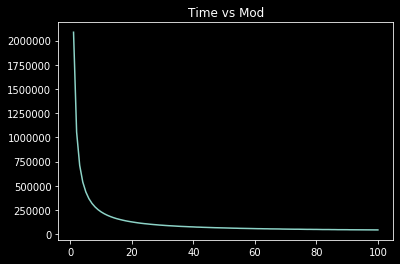

In [32]:
num_of_points = 10000
max_mod = 100

plt.title('Time vs Mod')

plt.plot(range(1, max_mod + 1), [predict_time(num_of_points, mod=mod) for mod in range(1, max_mod + 1)])
plt.show()

Now, we can see how the `num_of_points` on our generation of data affects the time it takes when using the `mod` as `num_of_points // 100`

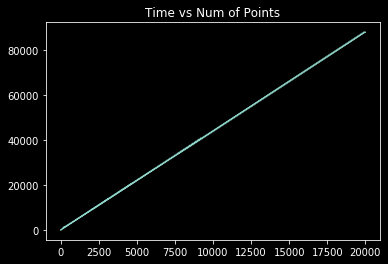

In [33]:
max_num_of_points = 20000

plt.title('Time vs Num of Points')

plt.plot(range(1, max_num_of_points + 1, 10), [predict_time(num_of_points, mod=(num_of_points // 100 if num_of_points > 100 else 1)) for num_of_points in range(1, max_num_of_points + 1, 10)])
plt.show()

Now to make a 3D graph to see how both of these parameters affect the times.

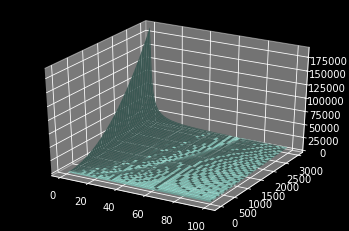

In [34]:
max_mod = 100
max_num_of_points = 3000

fig = plt.figure()
ax = fig.gca(projection='3d')

xs = np.arange(1, max_mod + 1)
ys = np.arange(1, max_num_of_points + 1, max_num_of_points / max_mod)
xs, ys = np.meshgrid(xs, ys)
zs = np.array([[predict_time(int(ys[i][j]), mod=int(xs[i][j])) for j in range(max_mod)] for i in range(max_mod)])

ax.plot_surface(xs, ys, zs)
plt.show()

Now, we will generate a bunch of samples using our random potentials from the methods above and our `solve_schrodinger_equation` method.

In [0]:
N = 100
h = L / N

x_points = np.arange(0, L, h)

np.random.seed(0)

def generate_sample(V):
    x_points, psi_points, E = solve_schrodinger_equation(V, N)
    inp = np.vectorize(V)(x_points) / e
    return inp, np.array([E / e] + psi_points)

inputs = []
outputs = []
file_name = 'dataset.npy'

if not regenerate_data:
    
    with open('dataset.npy', 'rb') as f:
        inputs, outputs = np.load(f)
    
else:

    print("Generating Dataset:")

    cur_time = time.time()

    num_of_points = 10000
    mod = num_of_points // 100

    for s in ['step', 'linear', 'fourier']:
        print('\r', s, 'potentials')
        for i in list(range(num_of_points // mod)) * mod:
            print("\rSize is", len(inputs), end='')
            def run():
                inp, target = generate_sample(generate_potential(s, i, p=int(np.random.random() * 6)))
                if np.nan not in inp and np.nan not in target:
                    inputs.append(inp)
                    outputs.append(target)
            try:
                func_timeout(60, run)
            except:
                print("\rData Point with Complexity", i, "timed out")

    print("\rDone - Took", to_readable_time(time.time() - cur_time), "seconds\n")


    print("Generated", len(inputs), "samples")

    inputs = np.array(inputs)
    outputs = np.array(outputs)

    with open(file_name, 'wb') as f:
        np.save(f, np.array([inputs, outputs]))


Now just some code to combine our current dataset with any other previous datasets.

In [36]:
# with open('dataset-1.npy', 'rb') as f:
#     n_inputs, n_outputs = np.load(f)
# inputs = np.concatenate([inputs, n_inputs])
# outputs = np.concatenate([outputs, n_outputs])

# with open('dataset.npy', 'wb') as f:
#         np.save(f, np.array([inputs, outputs]))
# inputs = n_inputs
# outputs = n_outputs
len(inputs), len(outputs)

(5991, 5991)

Checking for nan, inf, and very large numbers in dataset to mess around with scale until nothing prints here

In [0]:
for x in range(len(inputs)):
    inp = inputs[x]
    if np.nan in inp or np.inf in inp:
        print("nan is in inputs")
    for i in inp:
        if i > 1e10:
            print("inputs[" + str(x) + "]")
            break

for x in range(len(outputs)):
    out = outputs[x]
    if np.nan in out or np.inf in out:
        print("nan is in outputs")
    for o in out:
        if o > 1e10:
            print("outputs[" + str(x) + "]", o)
            break

Now, we have a couple preprocessing steps

*   Append the fourier transform of the input to our input data
*   Append the normalized version of the input to our input data
*   Append the min and max values of our potential

These are just to make our inputs more comprehensive of the potential

**NOTE:** I actually commented the line that actually called this since the neural network worked better without the extra parameters.


In [0]:
def preprocess(inputs, outputs):
    processed_inputs = []
    processed_outputs = []
    for inp, out in zip(inputs, outputs):
        norm_inp = inp - min(inp) if max(inp) == min(inp) else (inp - min(inp)) / (max(inp) - min(inp))
        fft_inp = np.fft.rfft(norm_inp)
        processed_inputs.append(np.concatenate((inp, norm_inp, np.real(fft_inp), np.imag(fft_inp), [min(inp), max(inp)])))
        processed_outputs.append([out[0] * 1e3] + list(out[1:]))
    return np.array(processed_inputs), np.array(processed_outputs)
# inputs, outputs = preprocess(inputs, outputs)

Now, we train a neural network on this dataset

In [39]:
print("Input Dim:", len(inputs[0]))

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='softplus', input_dim=len(inputs[0])),
    tf.keras.layers.Dense(512, activation='softplus'),
    tf.keras.layers.Dense(256, activation='softplus'),
    tf.keras.layers.Dense(len(outputs[0]), activation='linear')
])

model.compile(optimizer='adam',
              loss='mse')

model.summary()

epochs = 5

if retrain_model:
    history = model.fit(inputs, outputs, epochs=epochs)
    loss_history = history.history['loss']
    with open('loss_history.npy', 'wb') as f:
        np.save(f, np.array(loss_history))
else:
    model.load_weights('./model_weights.h5')
    with open('loss_history.npy', 'rb') as f:
        loss_history = np.load(f)

Input Dim: 100
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               25700     
Total params: 314,468
Trainable params: 314,468
Non-trainable params: 0
_________________________________________________________________


If you would like to train it more run this cell

In [0]:
retrain_epochs = 0
if retrain_epochs != 0:
    history = model.fit(inputs, outputs, epochs=retrain_epochs)
    loss_history = list(loss_history)
    loss_history += history.history['loss']
    with open('loss_history.npy', 'wb') as f:
        np.save(f, np.array(loss_history))

Now let's plot the loss as a function of epoch

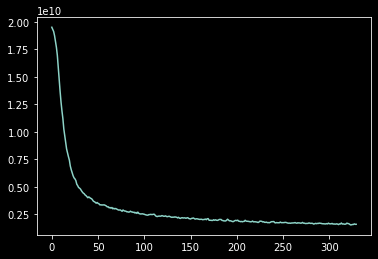

In [41]:
start = 0
end = len(loss_history)
plt.plot(range(len(loss_history))[start:end], loss_history[start:end])
plt.show()

In [42]:
# wanna_save = True
if wanna_save:
    model.save('./model_weights.h5')
    print("Model Saved!")
else:
    print("Not Saving Model")

Not Saving Model


Now, to see how our model does on a specific potential.

Energy: 13202.0188800707
Predicted Energy: 17659.66


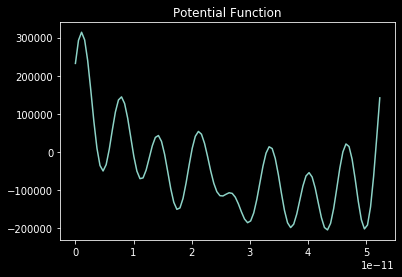

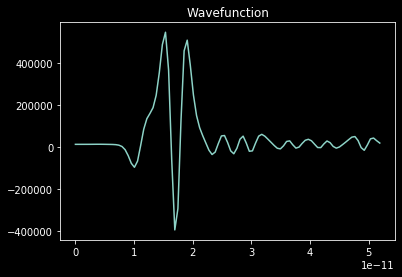

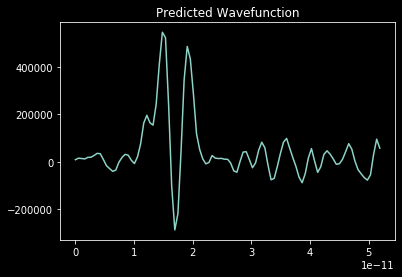

In [43]:
ind = 4000

print("Energy:", outputs[ind][0])
output = model.predict(np.array([inputs[ind]]))[0]

output = normalize(output)
print("Predicted Energy:", output[0])
plt.title("Potential Function")
plt.plot(x_points, inputs[ind][:len(x_points)])
plt.figure()
plt.title('Wavefunction')
plt.plot(x_points[:-1], outputs[ind][1:])
plt.figure()
plt.title('Predicted Wavefunction')
plt.plot(x_points[:-1], output[1:])
plt.show()

Now we apply Fourier smoothing to our model's predicted solution.

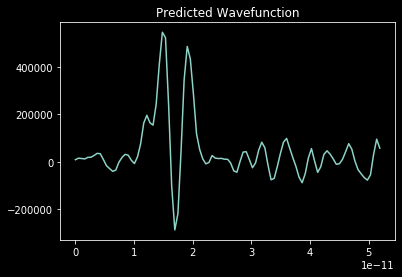

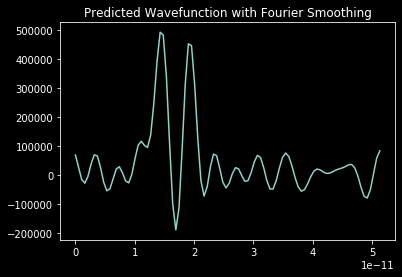

In [44]:
def smooth(y_points, starting_point_ratio=0.3):
    c_points = np.fft.rfft(y_points)
    c_points[int(starting_point_ratio * len(c_points)):] = 0
    return np.fft.irfft(c_points)

plt.title("Predicted Wavefunction")
plt.plot(x_points[:-1], output[1:])

plt.figure()
plt.title("Predicted Wavefunction with Fourier Smoothing")
plt.plot(x_points[:-2], smooth(output[1:]))
plt.show()

Save everything into drive

In [45]:
if save_to_drive:
    t = int(time.time())
    print("Key:", t)
    directory = "\"drive/My Drive/Colab Notebooks/Solving Schrodinger Equation Data/Data-" + str(t) + "\""
    ! mkdir $directory
    #  'dataset-0.npy', 'dataset-1.npy', 'dataset-2.npy',
    for file_name in ['dataset.npy', 'complexity_graphs.npy', 'loss_history.npy', 'model_weights.h5']:
        ! cp $file_name $directory
else:
    print("Not Saving To Drive")

Not Saving To Drive


Now, let us put all of this together into one method for the model.


Solving the Schrodinger numerically took 0.06661391258239746 seconds
Approximating the Schrodinger with a deep neural network took 0.027347803115844727 seconds
We had a 2.4358048908068524 times speed up
Solved Energy: 6546.746245487522 eV | Predicted Energy: -3478.5073 eV



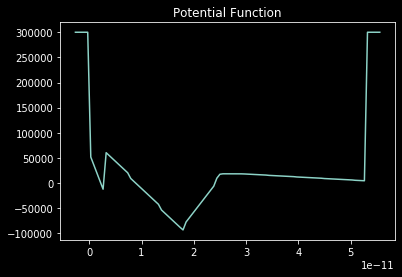

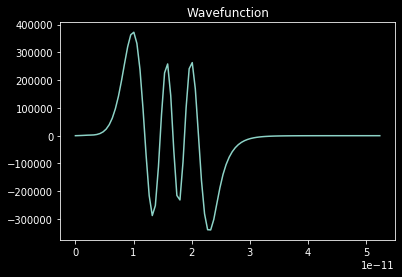

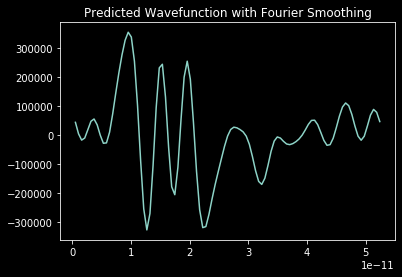

In [46]:
N = len(inputs[ind])

def predict_wavefunction(V):
    h = L / N
    V = np.array([[V(i * h) for i in range(N)]]) / e
    output = model.predict(V)[0]
    output = normalize(output)
    output[1:-1] = smooth(output[1:])
    return output[0], output[1:]

np.random.seed(4)
V = generate_potential('linear', 0)

ind = 2000
V2 = np.array([inputs[ind]])
V = lambda x: V2[0][min(int(x * N / L), N - 1)] * e

cur_time = time.time()
x_points, psi_points, E_solved = solve_schrodinger_equation(V, N=100)
numeric_time = time.time() - cur_time
print("\nSolving the Schrodinger numerically took", numeric_time, "seconds")

cur_time = time.time()
E_predicted, psi_points_predicted = predict_wavefunction(V)
neuralnet_time = time.time() - cur_time
print("Approximating the Schrodinger with a deep neural network took", neuralnet_time, "seconds")

print("We had a", numeric_time / neuralnet_time, "times speed up")

print("Solved Energy:", E_solved / e, "eV | Predicted Energy:", E_predicted, "eV\n")

plot_func(wrap_v(lambda x: V(x) / e, v0=0.3e6), -L/20, 1.05 * L, title='Potential Function')
plt.show()

plt.title("Wavefunction")
plt.plot(x_points, psi_points)
plt.show()

plt.title("Predicted Wavefunction with Fourier Smoothing")
plt.plot(x_points[1:], psi_points_predicted)
plt.show()

Now, let us visualize the times of how long each method will take to solve many functions.

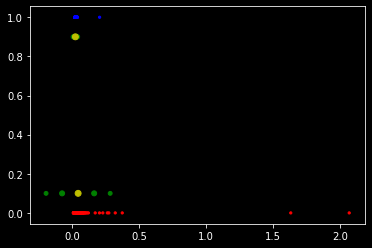

In [60]:
numeric_times = []
neuralnet_times = []

# M = len(inputs)
M =  500

for ind in range(M):
    V2 = np.array([inputs[ind]])
    V = lambda x: V2[0][min(int(x * N / L), N - 1)] * e

    cur_time = time.time()
    x_points, psi_points, E_solved = solve_schrodinger_equation(V, N=100)
    numeric_time = time.time() - cur_time
    numeric_times.append(numeric_time)

    cur_time = time.time()
    E_predicted, psi_points_predicted = predict_wavefunction(V)
    neuralnet_time = time.time() - cur_time
    neuralnet_times.append(neuralnet_time)

def mean(arr):
    return sum(arr) / len(arr)

def variance(arr):
    mu = mean(arr)
    return mean([(a - mu) ** 2 for a in arr])

def standard_deviation(arr):
    return variance(arr) ** 0.5

def is_outlier(a, arr):
    return abs(a - mean(arr)) > standard_deviation(arr) * 3

def plot_times():
    plt.scatter(numeric_times + neuralnet_times + [
        mean(numeric_times) - standard_deviation(numeric_times), 
        mean(neuralnet_times) - standard_deviation(neuralnet_times), 
        mean(numeric_times) + standard_deviation(numeric_times), 
        mean(neuralnet_times) + standard_deviation(neuralnet_times), 
        mean(numeric_times) - 2 * standard_deviation(numeric_times), 
        mean(neuralnet_times) - 2 * standard_deviation(neuralnet_times), 
        mean(numeric_times) + 2 * standard_deviation(numeric_times), 
        mean(neuralnet_times) + 2 * standard_deviation(neuralnet_times), 
        mean(numeric_times), 
        mean(neuralnet_times)
    ], [0] * len(numeric_times) + [1] * len(neuralnet_times) + [0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9], 
    c=['r'] * len(numeric_times) + ['b'] * len(neuralnet_times) + ['g'] * 8 + ['y', 'y'], 
    s=[5] * (len(numeric_times) + len(neuralnet_times)) + [25] * 4 + [15] * 4 + [35] * 2)
    plt.show()

plot_times()

In [67]:
print(len(numeric_times), len(neuralnet_times))
print(mean(numeric_times), mean(neuralnet_times))
print(standard_deviation(numeric_times), standard_deviation(neuralnet_times))

for numeric_time in numeric_times:
    if is_outlier(numeric_time, numeric_times):
        numeric_times.remove(numeric_time)

for neuralnet_time in neuralnet_times:
    if is_outlier(neuralnet_time, neuralnet_times):
        neuralnet_times.remove(neuralnet_time)

print()
print()

print(len(numeric_times), len(neuralnet_times))
print(mean(numeric_times), mean(neuralnet_times))
print(standard_deviation(numeric_times), standard_deviation(neuralnet_times))

477 449
0.03516988134484121 0.02575498859176126
0.0128085993842489 0.0014914874536153609


477 449
0.03516988134484121 0.02575498859176126
0.0128085993842489 0.0014914874536153609


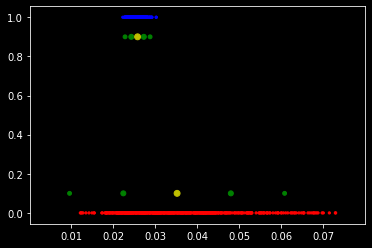

In [68]:
plot_times()

We can see from the graph above that the neural network times (blue) have a lower mean time and a smaller spread than the numeric times (red). This shows that the neural network, while the solutions are less accurate, solves our problem much faster and at a consistent rate rather than a slower inconsistent rate, showing the usefulness of using a neural network in this manner.

In conclusion, solving the Schrodinger equation analytically obviously yields the most accurate solutions. The numeric approximations provide us with pretty accurate solutions as well, but the trade off is that they can be quite slow to accurate solutions. Training our deep neural network on data where we used the numeric method to solve the schrodinger equations allow us to achieve solutions of comprable accuracy with just a simple and quick feed forward pass through our neural network.